In [1]:
#Import necessary packages
import math
import numpy as np
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%5.3f' % x})
import pandas as pd
from scipy.optimize import brute, fmin, minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

#Install import_ipynb so we can read dependenies as jupyter notebooks
!pip install ipynb

#Import jupyer notebook depdendencies 
from ipynb.fs.full.Lewis_Integration_option_valuation import BSM_call_value
from ipynb.fs.full.CIR_calibration import CIR_calibration , r_list
from ipynb.fs.full.CIR_zcb_valuation import B

In [2]:
#Import CSV file with option data as a panda dataframe
raw = pd.read_csv('C:/Users/1/Downloads/A_Python_in_financial_engineering/Project/option_data.csv')

#Convert variables Maturity and Date to pandas datetime objects
raw['Maturity']= pd.to_datetime(raw['Maturity'], format='%Y-%m-%d') 
raw['Date']= pd.to_datetime(raw['Date'], format='%Y-%m-%d')

In [3]:
#Create a copy so we do not have to reload the data set if we start over
data = raw.copy()
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Maturity  159 non-null    datetime64[ns]
 1   Strike    159 non-null    float64       
 2   Call      159 non-null    float64       
 3   Date      159 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 5.1 KB


,Maturity,Strike,Call,Date
0,2020-10-29,205.0,21.500,2020-10-26
1,2020-10-29,210.0,16.375,2020-10-26
2,2020-10-29,215.0,11.500,2020-10-26
3,2020-10-29,220.0,6.950,2020-10-26
4,2020-10-29,225.0,3.050,2020-10-26
...,...,...,...,...
154,2021-12-17,250.0,10.150,2020-10-26
155,2021-12-17,270.0,5.250,2020-10-26
156,2021-12-17,290.0,2.450,2020-10-26
157,2021-12-17,310.0,1.100,2020-10-26


In [4]:
#Create a variable, T, that shows how much, as a fraction of a year, that is left until maturity
data['diff'] = data['Maturity'] - data['Date']                     #number of days left to maturity
data['T']=(data['diff'].astype('timedelta64[D]').astype(int))/365  

#Drop unnecessary varibles
data.drop(['diff'], axis = 1, inplace=True)
options = data
options

,Maturity,Strike,Call,Date,T
0,2020-10-29,205.0,21.500,2020-10-26,0.008219
1,2020-10-29,210.0,16.375,2020-10-26,0.008219
2,2020-10-29,215.0,11.500,2020-10-26,0.008219
3,2020-10-29,220.0,6.950,2020-10-26,0.008219
4,2020-10-29,225.0,3.050,2020-10-26,0.008219
...,...,...,...,...,...
154,2021-12-17,250.0,10.150,2020-10-26,1.142466
155,2021-12-17,270.0,5.250,2020-10-26,1.142466
156,2021-12-17,290.0,2.450,2020-10-26,1.142466
157,2021-12-17,310.0,1.100,2020-10-26,1.142466


In [5]:
#Initial short rate (Eonia 3.12.2020). This should be the same date as the rest of the data of course
r0 = r_list[0]  

#Calibrate Short Rate Model to get calibrated estimates of CIR parameters used for zcb valuation
kappa_r, theta_r, sigma_r = CIR_calibration()

r = []
for row, option in options.iterrows():
    B0T = B([kappa_r, theta_r, sigma_r, r0, option['T']])
    r.append(-math.log(B0T) / option['T'])
options['r'] = r
options

Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 201
         Function evaluations: 382


,Maturity,Strike,Call,Date,T,r
0,2020-10-29,205.0,21.500,2020-10-26,0.008219,-0.004668
1,2020-10-29,210.0,16.375,2020-10-26,0.008219,-0.004668
2,2020-10-29,215.0,11.500,2020-10-26,0.008219,-0.004668
3,2020-10-29,220.0,6.950,2020-10-26,0.008219,-0.004668
4,2020-10-29,225.0,3.050,2020-10-26,0.008219,-0.004668
...,...,...,...,...,...,...
154,2021-12-17,250.0,10.150,2020-10-26,1.142466,0.000189
155,2021-12-17,270.0,5.250,2020-10-26,1.142466,0.000189
156,2021-12-17,290.0,2.450,2020-10-26,1.142466,0.000189
157,2021-12-17,310.0,1.100,2020-10-26,1.142466,0.000189


In [6]:
##################################################################################################################
################################################ Preliminaries ###################################################
#Define Stock price 
S0 = 226

#Slice the dataframe
#Default option selects all options in the csv file

#OR Choose only options that are within 2% of ATM 
#tol = 0.02  # percent ITM/OTM options
#options = [(np.abs(options['Strike'] - S0) / S0) < tol] 

#OR Choose specific strike prices 
# options = options[options['Strike'].isin([180, 200, 220, 240, 260])]

##################################################################################################################
############### Solve for B&S implied volatility with stochastic interest rates using Newton-Rhapson #############

def implied(c, S, K, T, r, n):
#Initial guess: https://www.researchgate.net/publication/245065192_
#                       A_Simple_Formula_to_Compute_the_Implied_Standard_Deviation

    initial_guess = np.sqrt(2 * np.pi / T) * c / S
    implied_vol = initial_guess
    for i in range(1, n):
        d1 = (np.log(S / K) + (r + 0.5 * implied_vol**2) * T) / (implied_vol * np.sqrt(T))
        d2 = d1 - implied_vol * np.sqrt(T)
        c0 = S * norm.cdf(d1) - K * np.exp(-r * T)*norm.cdf(d2)
        vega = S * norm.pdf(d1) * np.sqrt(T)
        implied_vol = implied_vol - (c0 - c) / vega
        #Need to include a condition that ensures that implied volatility is positive#########################
    return implied_vol

#Run the function 'implied' with max 10000 iterations using our pandas columns 
options['impVol'] = implied(options['Call'].values, S0, options['Strike'].values, options['T'].values, options['r'].values, 10000) 

##################################################################################################################
######################### Calculation of B&S option values with stochastic interest rates ########################

def BSM_calculate_model_values():
    ''' Calculates all model prices given implied volatility. '''  
    values = []
    for row, option in options.iterrows():
        model_value = BSM_call_value(S0, option['Strike'], option['T'], option['r'], option['impVol'])
        values.append(model_value)
    return np.array(values) 

##################################################################################################################
################################################# Run calibration ################################################

if __name__ == '__main__': 
    
    #Create pandas column for BSM call options values based on calibrated data
    options['Model'] = BSM_calculate_model_values()


In [7]:
#Drop max.rows option so we can see full dataframe 
pd.set_option('display.max_rows', None)

#Drop all rows where NaN exists in the impVol column
options.dropna(subset=['impVol'], how='all', inplace=True)

#Only keep the rows with positive implied volatilities (can be taken care of in the implied vol calc. instead)
options = options[options['impVol'] >= 0]
options

,Maturity,Strike,Call,Date,T,r,impVol,Model
0,2020-10-29,205.0,21.500,2020-10-26,0.008219,-0.004668,0.753593,21.500000
1,2020-10-29,210.0,16.375,2020-10-26,0.008219,-0.004668,0.565914,16.375000
2,2020-10-29,215.0,11.500,2020-10-26,0.008219,-0.004668,0.456871,11.500003
3,2020-10-29,220.0,6.950,2020-10-26,0.008219,-0.004668,0.380333,6.949879
4,2020-10-29,225.0,3.050,2020-10-26,0.008219,-0.004668,0.309399,3.051194
5,2020-10-29,230.0,0.850,2020-10-26,0.008219,-0.004668,0.281964,0.848910
7,2020-11-06,205.0,21.625,2020-10-26,0.030137,-0.004556,0.418592,21.625000
8,2020-11-06,210.0,17.000,2020-10-26,0.030137,-0.004556,0.387795,17.000000
9,2020-11-06,215.0,12.500,2020-10-26,0.030137,-0.004556,0.347515,12.500000
10,2020-11-06,220.0,8.400,2020-10-26,0.030137,-0.004556,0.313473,8.400000


In [8]:
#Create a variable, T, that shows how much, as a fraction of a year, that is left until maturity
options['diff'] = options['Maturity'] - options['Date']     #number of days left to maturity

#Create a new variable equal to 'diff' but in the integer format not the timedelta64 format
options['Days'] = options['diff'].astype('timedelta64[D]').astype(int)

#Createa a vector of unique maturities
maturities = options.Days.unique()
maturities 

array([3.000000, 11.000000, 18.000000, 25.000000, 32.000000, 53.000000,
       81.000000, 144.000000, 235.000000, 326.000000, 417.000000])

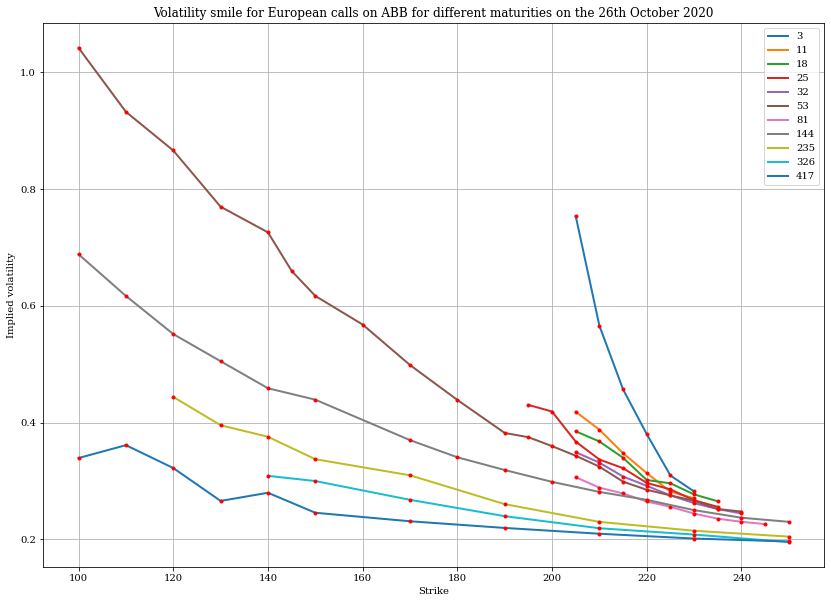

In [9]:
#Plot the implied volatilties in a line plot
plt.figure(figsize=(14, 10))                           #set size of figure
for maturity in maturities:                            #maturities is a list created earlier
    iv_plot = options[options.Days == maturity] #defines maturity as the unique numbers in the Days column of the data set
    #Select x and y values for plot for each maturity
    plt.plot(iv_plot['Strike'], iv_plot['impVol'], label=maturity, lw=2)
    plt.plot(iv_plot['Strike'], iv_plot['impVol'], 'r.', label='')
plt.grid(True) 
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.title('Volatility smile for European calls on ABB for different maturities on the 26th October 2020')
plt.legend()

In [10]:
#Drop all rows which which have call options that are very deep out of the money (Strike < 170)
options = options[options['Strike'] >= 190 ]
options = options[options['Strike'] <= 260 ]

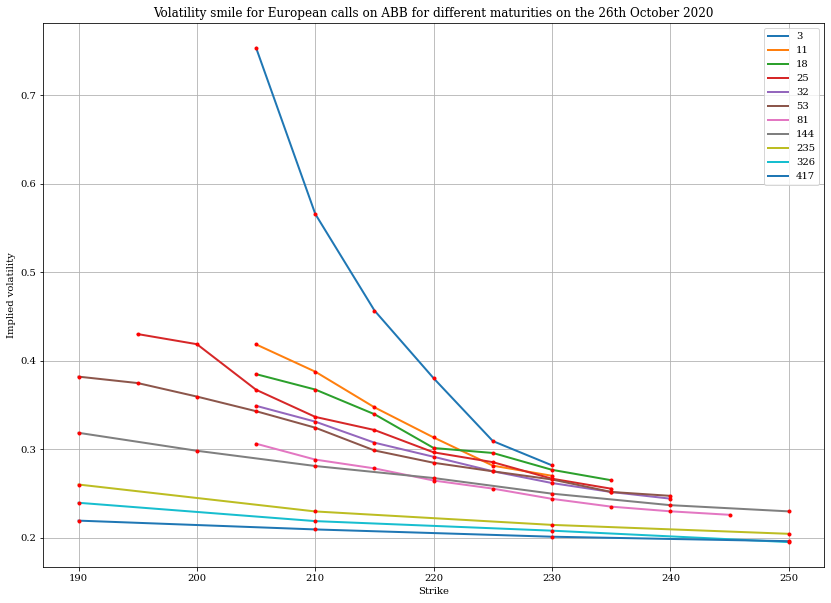

In [11]:
#Plot the implied volatilties in a line plot
plt.figure(figsize=(14, 10))                           #set size of figure
for maturity in maturities:                            #maturities is a list created earlier
    iv_plot = options[options.Days == maturity] #defines maturity as the unique numbers in the Days column of the data set
    #Select x and y values for plot for each maturity
    plt.plot(iv_plot['Strike'], iv_plot['impVol'], label=maturity, lw=2)
    plt.plot(iv_plot['Strike'], iv_plot['impVol'], 'r.', label='')
plt.grid(True) 
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.title('Volatility smile for European calls on ABB for different maturities on the 26th October 2020')
plt.legend()